In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
import os
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output


In [4]:
print("Loading dataset...")
fake = pd.read_csv('data/Fake.csv')
true = pd.read_csv('data/True.csv')

fake['label'] = 1  # Fake = 1
true['label'] = 0  # Real = 0

df = pd.concat([fake, true], ignore_index=True)
df = df[['title', 'text', 'label']]
df['article'] = df['title'] + " " + df['text']

print(f"Total articles: {len(df)}")
print(f"Fake: {sum(df['label']==1)}, Real: {sum(df['label']==0)}")

Loading dataset...
Total articles: 44898
Fake: 23481, Real: 21417


In [5]:
print("Cleaning articles...")
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_article'] = df['article'].apply(clean_text)
print("Articles cleaned and 'clean_article' column created.")

Cleaning articles...
Articles cleaned and 'clean_article' column created.



Exploratory Analysis...


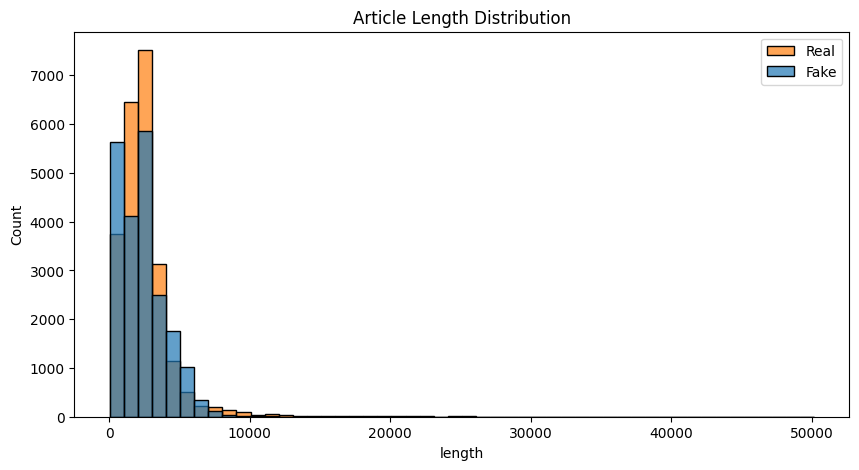

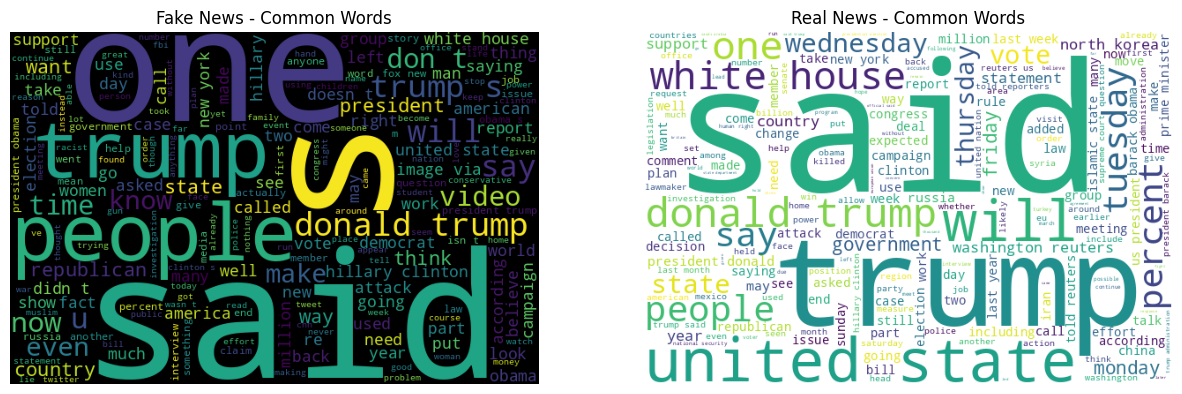

In [6]:
print("\nExploratory Analysis...")
plt.figure(figsize=(10,5))
df['length'] = df['clean_article'].apply(len)
sns.histplot(data=df, x='length', hue='label', bins=50, alpha=0.7)
plt.title('Article Length Distribution')
plt.legend(['Real', 'Fake'])
plt.show()

# Word Clouds
fake_text = " ".join(df[df['label']==1]['clean_article'])
real_text = " ".join(df[df['label']==0]['clean_article'])

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
wordcloud_fake = WordCloud(width=600, height=400, background_color='black').generate(fake_text)
plt.imshow(wordcloud_fake)
plt.title('Fake News - Common Words')
plt.axis('off')

plt.subplot(1,2,2)
wordcloud_real = WordCloud(width=600, height=400, background_color='white').generate(real_text)
plt.imshow(wordcloud_real)
plt.title('Real News - Common Words')
plt.axis('off')
plt.show()

In [7]:
print("Performing Train-Test Split...")
X = df['clean_article']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Performing Train-Test Split...
X_train shape: (35918,)
X_test shape: (8980,)
y_train shape: (35918,)
y_test shape: (8980,)


In [8]:
print("\nTraining TF-IDF Vectorizer...")
vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")


Training TF-IDF Vectorizer...
X_train_tfidf shape: (35918, 50000)
X_test_tfidf shape: (8980, 50000)


In [9]:
print("\nTraining Logistic Regression model...")
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
print("Logistic Regression model trained.")


Training Logistic Regression model...
Logistic Regression model trained.



Evaluating Model...

Accuracy: 99.12%
Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      4284
        Fake       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



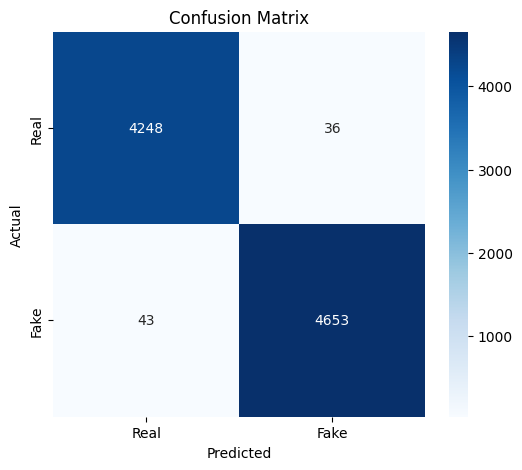

In [10]:
print("\nEvaluating Model...")
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy*100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [11]:
print("\nSaving Model and Vectorizer...")

# Create the 'model' directory if it doesn't exist
os.makedirs('model', exist_ok=True)

joblib.dump(model, 'model/final_model.pkl')
joblib.dump(vectorizer, 'model/vectorizer.pkl')
print("Model and vectorizer saved to 'model/' directory!")


Saving Model and Vectorizer...
Model and vectorizer saved to 'model/' directory!


In [12]:
print("\nInteractive Fake News Detector")
print("Paste any news article below and click 'Check'")

text_input = widgets.Textarea(
    value='',
    placeholder='Paste news article here...',
    description='Article:',
    layout={'height': '200px', 'width': '100%'}
)

button = widgets.Button(description="Check if Fake", button_style='danger')
output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output()
        if text_input.value.strip() == "":
            print("Please enter some text.")
            return
        cleaned = clean_text(text_input.value)
        vec = vectorizer.transform([cleaned])
        pred = model.predict(vec)[0]
        prob = model.predict_proba(vec)[0]
        confidence = max(prob) * 100

        result = "FAKE" if pred == 1 else "REAL"
        color = "red" if pred == 1 else "green"

        print(f"\nPrediction: {result}")
        print(f"Confidence: {confidence:.2f}%")
        print("\nTop predictive words (sample):")
        feature_names = vectorizer.get_feature_names_out()
        coef = model.coef_[0]
        top_fake = sorted(zip(coef, feature_names), reverse=True)[:10]
        top_real = sorted(zip(coef, feature_names))[:10]
        print("Strong 'Fake' indicators:", [word for score, word in top_fake[:5]])
        print("Strong 'Real' indicators:", [word for score, word in top_real[:5]])

button.on_click(on_button_click)
display(text_input, button, output)


Interactive Fake News Detector
Paste any news article below and click 'Check'


Textarea(value='', description='Article:', layout=Layout(height='200px', width='100%'), placeholder='Paste new…

Button(button_style='danger', description='Check if Fake', style=ButtonStyle())

Output()